Single qubit errors validated against Egan paper
========================================

This is a simulation of single qubit errors in an ion trap quantum computer to compare a qiskit noise model with experiments by Egan [1].  The noise model will be used on our simulation of the Steane code.

This simulation uses the randomised benchmark function from qiskit to simulate Egan's characterization of single qubit errors.  A circuit is constructed with N-1 sequential random Clifford gates and a final Clifford gate that inverts the others.  In the circuit diagram below the Clifford gates are separated by a barrier.

With no noise the qubit will always finish in the starting |0> ground state.  A simulation was run and the ground state population is shown plotted against the number of Clifford gates.  For comparison a calculation of the expected ground state population using a error per Clifford gate of 3.4(8)×10−4 as quoted by Egan is shown.

There are two caveats to this simulation.

Firstly the Clifford gate composition provided by qiskit decomposes each Clifford gate into native qiskit gates including the Pauli gates, X, Y, Z, the Hadamard, the S or Phase gate and it's inverse SDG.  Each Clifford gate is a composition of up to four gates, for example, XSHS.  There are an average of around 2.4 of the native gates for each Clifford gate. Egan used a different native gate set with gates like X/2 and had an average of only 1.875 gates for each Clifford gate.  Since the quiskit simulation has more gates there are more chances for error and a lower ground state population is expected.   

Secondly we use a depolarising error with a parameter which represents the chance that a X, Y, Z and I error occurs.  Since a Z and I error won't be detectable we have doubled Egan's stated error of 1.8(3)×10−4 per native Pauli gate to use as the depolarising error parameter.

Our simulation shows results broadly aligned with Egan.  The single gate error is much less that the two gate error and is neglected in some simulations.  On this basis our error model is reasonable.

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.quantum_info import Clifford

# Import the randomized benchmarking Function
import qiskit.ignis.verification.randomized_benchmarking as rb

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import random
import matplotlib.pyplot as plt
import numpy as np

Define constants so the process flow can be controlled from one place:

In [2]:
SHOTS = 10000                            #Number of shots to run 
ITERATIONS = 25                          #Number of iterations for each simulation
MEASURE_NOISE = 0.0046                   #Measurement noise
SINGLE_GATE_NOISE = 0.000183 * 2         #Parameter for depolarising channel
SINGLE_CLIFFORD_GATE_NOISE = 0.000348    #Used to calculate theory 
NOISE = True                             #Test with noise?

GATE_LIST = [1, 3, 7, 11, 15, 19]        #Number of Clifford gate to be simulated
                                         # one more reversal gate is automaticaly added
#GATE_STEP = 4

SIMULATOR = Aer.get_backend('qasm_simulator')

In [3]:
# Generate randomised benchcircuit 

rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = GATE_LIST
# Number of seeds (random sequences)
rb_opts['nseeds'] = ITERATIONS
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

Draw a random circuit for four Clifford gates.

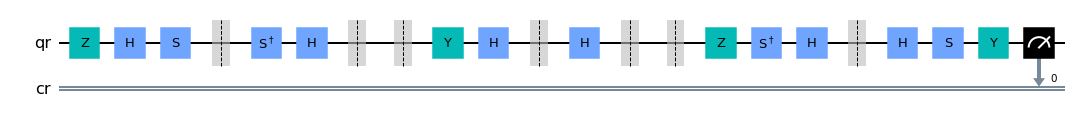

In [4]:
rb_circs[0][2].draw(output='mpl', filename = 'auto_qubit.jpg', fold=60)

In [5]:
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    error_gate3 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors
    noise_model.add_all_qubit_quantum_error(error_gate2, ['cx']) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate3, ['cz']) # same two qubit gate error is applied to cz gates

    return noise_model

In [6]:
noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_NOISE)


In [7]:
theoretical_probability1 = []
theoretical_probability2 = []
number_of_gates_line = []

for gate_number in GATE_LIST:
    #exponent1 = (gate_number + 1) * 2.44
    #gate_noise1 = ((1 - SINGLE_GATE_NOISE / 2) ** exponent1) 
    #theory1 = gate_noise1 * (1 - MEASURE_NOISE)
    exponent2 = (gate_number + 1) 
    gate_noise2 = ((1 - SINGLE_CLIFFORD_GATE_NOISE) ** exponent2) 
    theory2 = gate_noise2 * (1 - MEASURE_NOISE)        
    #theoretical_probability1.append(theory1)
    theoretical_probability2.append(theory2)
    number_of_gates_line.append(gate_number + 1)                             

In [8]:
simulation_probability = []
mean_probability = []
number_of_gates_scatter = []

loop_number = 0
for gate_depth in GATE_LIST:
    accumulator = 0
    for iteration in range(ITERATIONS):
        if NOISE:
            result = execute(rb_circs[iteration][loop_number], SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
        else:
            result = execute(rb_circs[iteration][loop_number], SIMULATOR, shots=SHOTS).result()     
        counts = result.get_counts(rb_circs[iteration][loop_number])
        #print ('The different states can be counted.  The simulated result are', counts, loop_number, gate_number)
        number_of_gates_scatter.append(gate_depth + 1)
        # need to add one gate to allow for the reversal
        probability = counts.get('0') / SHOTS
        simulation_probability.append(probability)
        accumulator = accumulator + probability
        #print(accumulator, probability)
    mean = accumulator / ITERATIONS
    print(f' For {gate_depth + 1} gates the mean ground state population probability is {mean:.4f}')
    mean_probability.append(mean)
    loop_number = loop_number + 1

 For 2 gates the mean ground state population probability is 0.9946
 For 4 gates the mean ground state population probability is 0.9936
 For 8 gates the mean ground state population probability is 0.9924
 For 12 gates the mean ground state population probability is 0.9905
 For 16 gates the mean ground state population probability is 0.9892
 For 20 gates the mean ground state population probability is 0.9872


Plot graph:

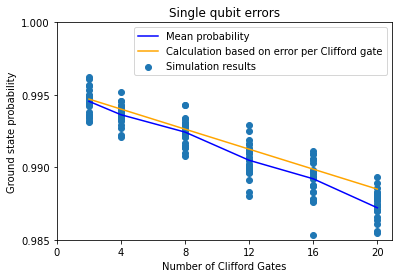

In [9]:
#graph constants
YMIN = 0.985
YMAX = 1.000
YTICK = 0.005

#graph
title_text = "Ground state probabilty against number of Clifford Gates"
plt.scatter(number_of_gates_scatter, simulation_probability, label = "Simulation results" )
plt.plot(number_of_gates_line, mean_probability, label = "Mean probability for simulation" , color="blue")
#plt.plot(number_of_gates_line, theoretical_probability1, label = "Single gate" )
plt.plot(number_of_gates_line, theoretical_probability2, label = "Calculation based on error per Clifford gate" , color="orange")
plt.title('Single qubit errors')
plt.xlabel('Number of Clifford Gates')
plt.ylabel('Ground state probability')  
plt.legend()
plt.ylim(YMIN, YMAX)
plt.xticks(np.arange(0, 21, 4))
plt.yticks(np.arange(YMIN, YMAX, YTICK))
fname = "single_qubit_errors.png"
plt.savefig(fname)

In the graph above the offset corresponds to the state preparation and measurement (SPAM) error of 0.0046 reported by Egan.

The slope gives the error per Clifford gate.  Since this is small the graph is approximated linear.